In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks/머신러닝/5장/자전거 수요

/content/drive/MyDrive/Colab Notebooks/머신러닝/5장/자전거 수요


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv('train.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
df1.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
df1['datetime'] = pd.to_datetime(df1['datetime'])

In [7]:
df1['year'] = df1['datetime'].dt.year
df1['month'] = df1['datetime'].dt.month
df1['day'] = df1['datetime'].dt.day
df1['hour'] = df1['datetime'].dt.hour
df1.drop(['datetime', 'casual', 'registered'], axis = 1, inplace = True) # casual과 registered는 count와 상관관계가 높으므로 삭제

In [8]:
df1.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
def rmse(Y, pred): # 모델 평가
  return np.sqrt(mean_squared_error(Y, pred))

Y_df = df1['count']
X_df = df1.drop('count', axis = 1, inplace = False)

X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, test_size = 0.2)

lr = LinearRegression()
lr.fit(X_train, Y_train)
pred = lr.predict(X_test)

rmse(Y_test, pred)

141.02384981636075

In [ ]:
def get_top_error_data(Y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(Y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(Y_test,pred,n_tops=20)

      real_count  predicted_count   diff
752          731            146.0  585.0
117          968            410.0  558.0
804          798            244.0  554.0
1348         745            192.0  553.0
212          678            133.0  545.0
727          721            177.0  544.0
925          713            170.0  543.0
1111         666            144.0  522.0
1317         711            201.0  510.0
759          868            361.0  507.0
1950         681            176.0  505.0
1421         668            166.0  502.0
1602         863            368.0  495.0
523          872            377.0  495.0
2071         639            152.0  487.0
1959         835            355.0  480.0
1122         854            375.0  479.0
347          650            171.0  479.0
1196         877            404.0  473.0
1787         683            210.0  473.0


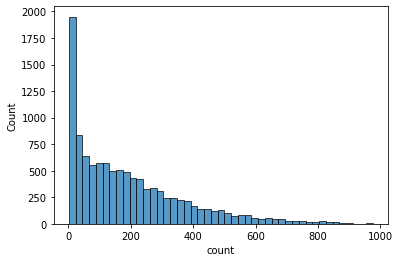

In [10]:
sns.histplot(data = Y_df) # 종속 변수가 정규분포인지 확인 ==> 회귀에서 target이 정규분포 형태를 띄는 것이 중요

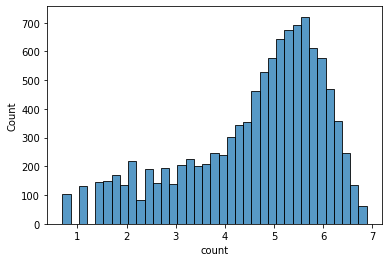

In [11]:
Y_transformed = np.log1p(Y_df) # 정규분포 형태로 만들기 위해
sns.histplot(Y_transformed)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_transformed, test_size = 0.2)

lr = LinearRegression()
lr.fit(X_train, Y_train)
pred = lr.predict(X_test)

Y_test_exp = np.expm1(Y_test)

# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)
rmse(Y_test_exp, pred_exp)

156.23267916238999

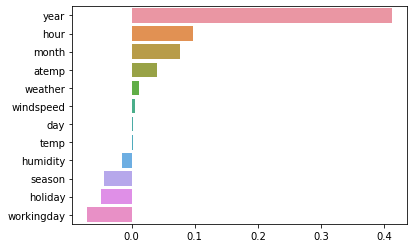

In [16]:
coef = pd.Series(lr.coef_, index=X_df.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index) # year의 회귀계수가 제일 큼 ==> 좋지 않음

In [17]:
# 'year','month','hour','season','weather' feature들을 One Hot Encoding
X_df_oh = pd.get_dummies(X_df, columns=['year','month','hour', 'holiday', 'workingday','season','weather'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_df_oh, Y_transformed, test_size=0.2)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    print(rmse(y_test, pred))
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.001)
svm_reg = SVR(kernel='rbf', C=100)

for model in [lr_reg, ridge_reg, lasso_reg, svm_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
94.0775925139203
### Ridge ###
95.61619308416408
### Lasso ###
95.56542608619151
### SVR ###
83.79248056674018


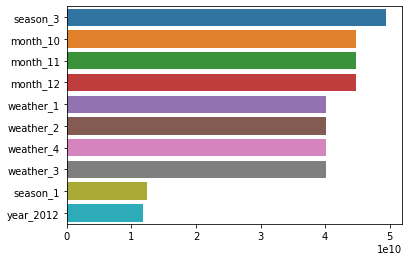

In [19]:
coef = pd.Series(lr_reg.coef_ , index=X_df_oh.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)